Mona Mokart
# TP3 IMA207 : Blind souce separation
_____________________

In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

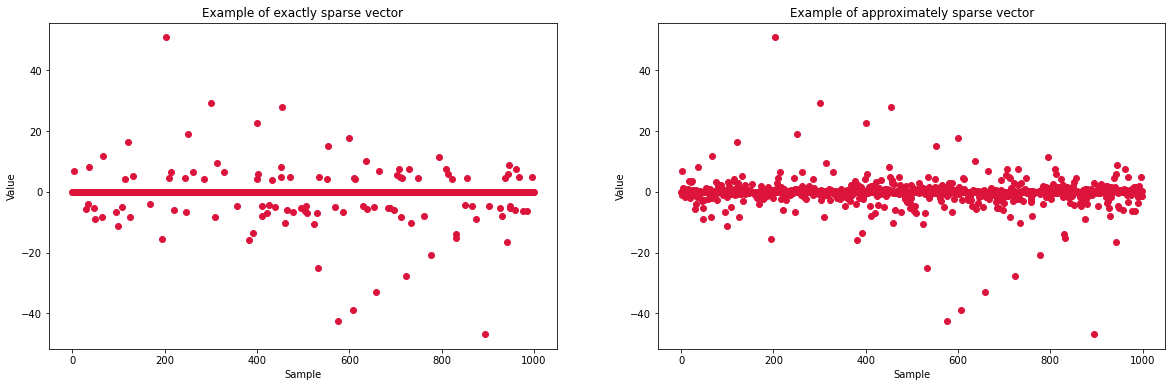

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o', c="crimson")
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o', c="crimson")
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Réponse** : 
Un signal approximativement sparse va avoir beacoup de valeurs proches de zéro sans réellment atteindre zéro. Un signal exactement sparse va avoir un grand nombre de valeurs exactement égales à zéro et peu de valeur non nulles

**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

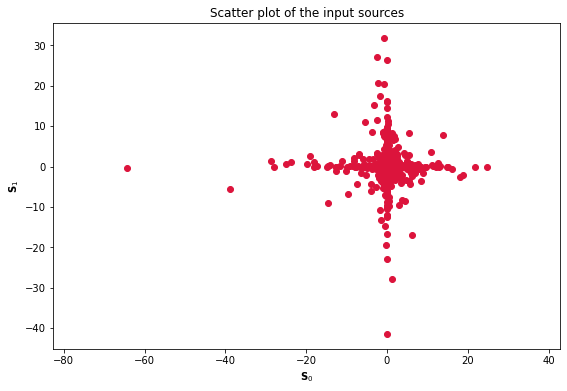

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
approx_sparse1 = np.random.randn(t)**power
#exact_sparse1 = approx_sparse1*(np.abs(approx_sparse1)>4)

approx_sparse2 = np.random.randn(t)**power
#exact_sparse2 = approx_sparse2*(np.abs(approx_sparse2)>4)

S = np.zeros((n,t))
S[0] = approx_sparse1
S[1] = approx_sparse2
# TO CHANGE

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o', c="crimson")
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

**Réponse** : Puisque que pour S0 il y a peu de valeurs élevées, loins de zero et pareil pour S1, il y a peu de chance qu'un point de S1xS2 ait à la fois une abcisse et une ordonnée élevée. Cela explique qu'il y a peu points en dehors de l'axe des abscisses(s1=0) ou l'axe des ordonnées(s0=0). On remarque alors une "croix" avec de plus une zone dense de points vers les coordonnées (0,0).

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations
np.random.seed(3)
A = np.random.randn(m,n)
#A = np.ones((m,n))
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

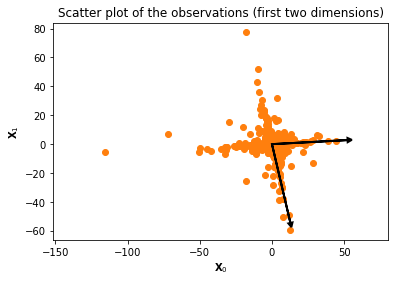

In [5]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');


**Réponse**:


<u>Noise:</u>
- Quand le noise_level est petit (beaucoup de bruit), on n'arrive plus à distinguer les sources S0 et S1 à l'oeil nu.
- Quand le noise_level est grand cela devient facile à distinguer les axes S0 et S1

<u>A:</u> De manière générale, multiplier X par S va changer la direction des axes
- si A est une patrice de 1 alors tous les spectres sont les mêmes et X va donc observer une droite dans les observations 
- si A est une matrice aléatoire, on va réussir à retrouver à l'oeil nu les axes S0 et S1

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

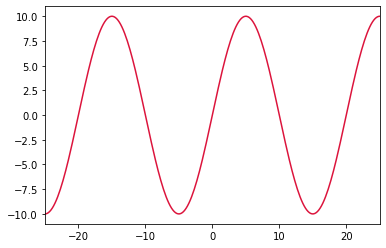

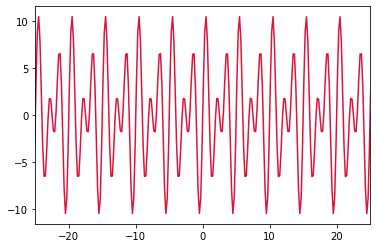

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs) + 6*np.sin(2*np.pi*0.6*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:], c="crimson")
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:], c="crimson")
plt.xlim([-25,25])
plt.show()

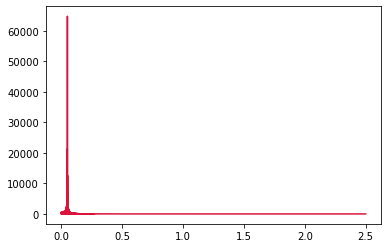

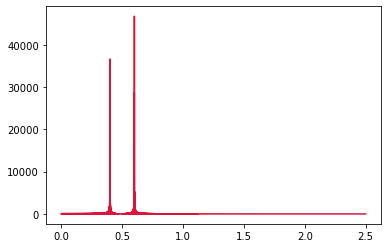

In [8]:
# Transformation into the DCT domain
Sf = sff.dct(S)
# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.

plt.figure(),plt.plot(x_abs/800 + 1.25,np.abs(Sf[0,:]), c="crimson")
plt.figure(),plt.plot(x_abs/800 + 1.25,np.abs(Sf[1,:]), c="crimson")
plt.show()

Ici on a des signaux qui ne sont pas sparses mais qui peuvent être un somme de signaux de différentes fréquences, ainsi en passant dans un autre espace, ici grâce à la dct on rend les signaux sparses. Cela permet de distinguer les fréquences qui ont été sommées.

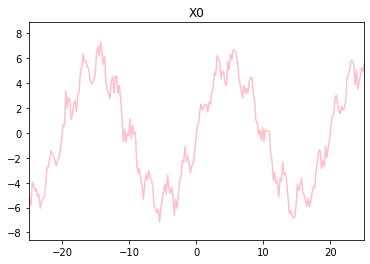

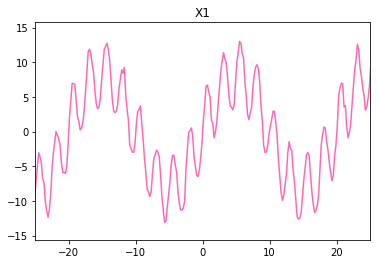

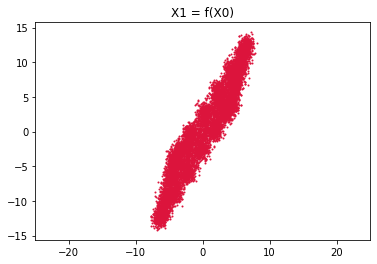

In [15]:
# Data generation : now, we will create a mixture X = AS + N
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)
Sf = sff.dct(S)  # je remet un sinus simple


X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values
plt.figure()
plt.plot(x_abs, X[0], color="pink")
plt.xlim(-25, 25)
plt.title("X0")

plt.figure()
plt.plot(x_abs, X[1], color="hotpink")
plt.xlim(-25, 25)
plt.title("X1")

plt.figure()
plt.scatter(X[0], X[1], s=1, color="crimson")
plt.xlim(-25, 25)
plt.title("X1 = f(X0)")
plt.show()
# TO DO : plot the mixtures. Explain what you see.
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Réponse** : Ici on n'observe plus des croix dans le graphe de X1 en fct de X0. Cela est du au fait que le signal n'est pas sparse.

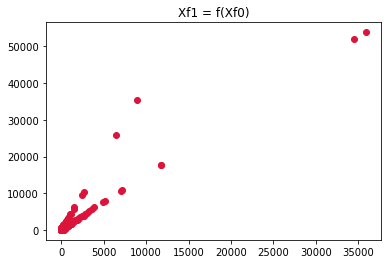

In [19]:
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?
Xf = (sff.dct(X))
plt.scatter(np.abs(Xf[0]), np.abs(Xf[1]), color="crimson")
plt.title("Xf1 = f(Xf0)")
plt.show()

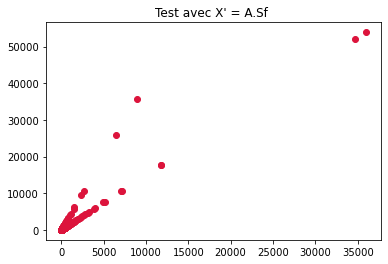

In [20]:
# test en appliquant X = A@Sf
X_ = A@np.abs(sff.dct(S))
plt.scatter(X_[0], X_[1], color="crimson")
plt.title("Test avec X' = A.Sf ")
plt.show()

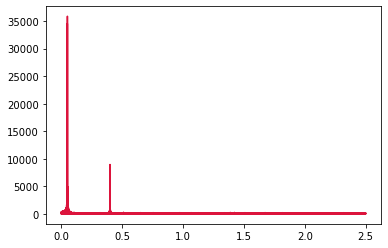

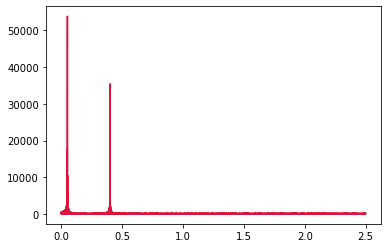

In [21]:
plt.figure(),plt.plot(x_abs/800 + 1.25,np.abs(Xf[0,:]), c="crimson")
plt.figure(),plt.plot(x_abs/800 + 1.25,np.abs(Xf[1,:]), c="crimson")
plt.show()

**Réponse** : En utilisant la DCT on arrive à distinguer la propriété sparse des sources.  

- On remarque qu'en appliquant directement la DCT sur X on obtient le même résultat que si on avait appliqué la DCT sur S les sources avant. 
Cela est dû à la propriété linéaire de la DCT.

- On le voit bien sur les derniers graphes, que Xf est une combinaison linéaire de DCT(S1) et DCT(S2)

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Réponse**:
L(S) = $\frac{1}{2} ||X-AS||_F^2 + \lambda||S||_1$

La première partie correspond à trouver le S qui se rapproche le plus de l'observation et le multipliant par A, la deuxième partie et une sparsity constraint pour essayer d'avoir des sources sparses

La première partie est smooth et différentiable
La norme 1 n'est pas différentiable (et non smooth) 

Cette fonction est convexe mais pas strictement convexe 

**2-2)** Compute the gradient along the S variable of the data-fidelity term.

**Réponse**: $ f(S) = \frac{1}{2} ||X-AS||_F^2 $

$\nabla f(S) = -A^T(X-AS)$


**2-3)**

Recall what the proximal operator of the l1-norm is.

**Réponse**:
- it is the soft-tresholding operator: 
$prox_{\lambda||.||_1}(A)_{ij} = \left \{ \begin{array}{} a_{ij}-\lambda \;\; , a_{ij} > \lambda \\ 0 \;\;  ,|a_{ij}| \leq \lambda \\ a_{ij}+\lambda \;\;  , a_{ij} < -\lambda \end{array} \right.$

In [11]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
#  # To complete
    S_est[S_est>thrd] -=  thrd
    S_est[S_est<-thrd] += thrd
    S_est[abs(S_est)<=thrd] = 0
    return S_est

**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

In [12]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    gamma = 0.9/np.linalg.norm(A.T@A)
    S_est = np.random.rand(A.shape[1], X.shape[1])
    print(A.shape, S_est.shape, X.shape)
    for i in range(nbIt):
        S_est = prox_l1(S_est + gamma*A.T@(X-A@S_est), lamb*gamma)
    return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

In [13]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

(2, 2) (2, 10000) (2, 10000)


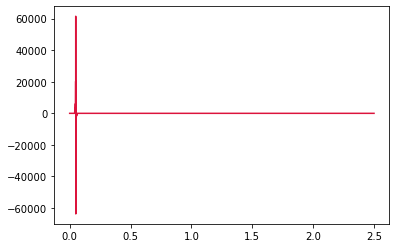

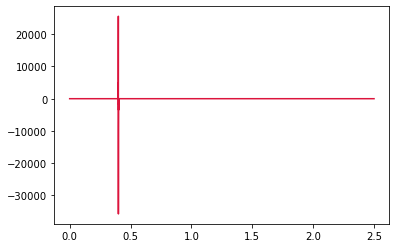

In [14]:
# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.figure(),plt.plot(x_abs/800 + 1.25, S_estf[0,:], c="crimson")
plt.figure(),plt.plot(x_abs/800 + 1.25, S_estf[1,:], c="crimson")
plt.show()

**Réponse** :On retrouve bien le signal des deux sources avec lambda = 1000. Cependant en jouant avec les valeurs de lambda on observe que :
- Quand $\lambda$ est trop petit (proche de zéro), il n'y a plus de contrainte sur la sparity des sources et on obtient un pic élevé comme prévu mais avec du bruit (léger) en amplitude sur toute la plage de fréquence 
- Quand $\lambda$ est trop élevé la contrainte sur la sparsity des sources est trop grand et le signal résultant est nul

**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

(-25.0, 25.0)

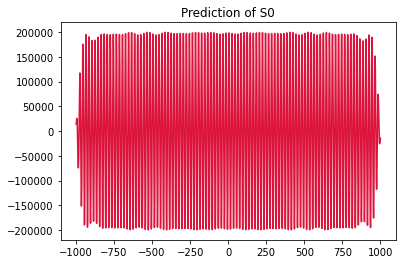

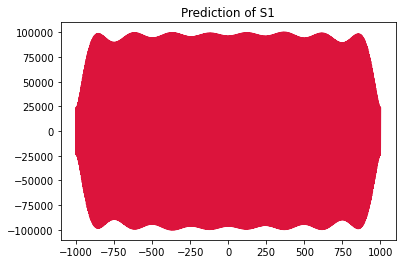

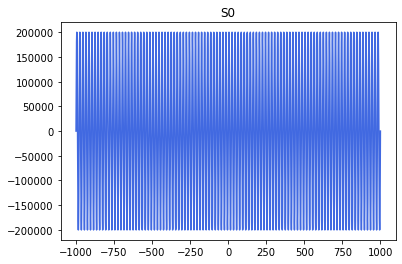

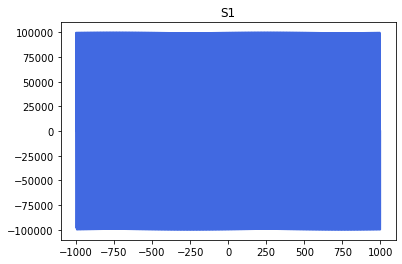

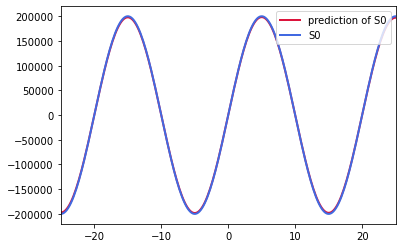

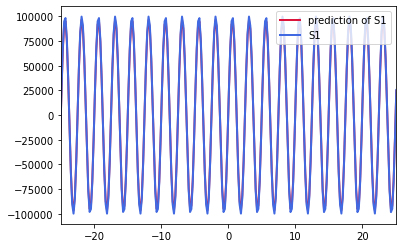

In [15]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.
St_pred = sff.idct(S_estf)
St = sff.idct(Sf)

plt.figure(),plt.plot(x_abs, St_pred[0,:], color="crimson"), plt.title("Prediction of S0")

plt.figure(),plt.plot(x_abs, St_pred[1,:], color="crimson"), plt.title("Prediction of S1")

plt.figure(),plt.plot(x_abs, St[0,:], color="royalblue"), plt.title("S0")

plt.figure(),plt.plot(x_abs, St[1,:], color="royalblue"), plt.title("S1")



# TO DO : compare the central parts of the original and estimated sources.

plt.figure()
plt.plot(x_abs, St_pred[0,:], color="crimson", lw=2, label="prediction of S0")
plt.plot(x_abs, St[0,:], color="royalblue", lw=2, label="S0")
plt.legend(loc="upper right")
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, St_pred[1,:], color="crimson", lw=2, label="prediction of S1")
plt.plot(x_abs, St[1,:], color="royalblue", lw=2, label="S1")
plt.legend(loc="upper right")
plt.xlim([-25,25])
# CORRECTION : denoising : even with relatively high noise levels, the sources are quite well denoised.

**Réponse**:On remarque que sur la plage entière des abscisses il y a une petite différence entre les prédictions et les signaux originaux au niveau des amplitudes, cela doit être dû au fait que le signal préditdans l'espace des fréquences n'est pas totalement sparse. Ainsi on observe la somme du sinus principal et d'autres fréquences mais très faibles en amplitude ce qui donne ce résultat. 

En revanche, sur une plus petite échelle, les signaux et leurs prédictions se superposent 

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Réponse**:
L(A,S) = $\frac{1}{2} ||X-AS||_F^2 + \lambda||S||_1 +\iota_{||a_{i,j}||^2_2=1}$


Ici en plus des parties précédentes on ajoute une nouvelle partie qui est une forte contrainte sur A, on lui impose d'avoir une norme unitaire.
L'indicatrice n'est pas smooth ni convexe

Finalement la fonction de loss ni smooth si convexe 

2) Recall what the gradient of the data fidelity term over A is.

$-(X-AS)S^T$

3) Compte the proximal operator of the oblique constraint. Implement it.

In [16]:
def prox_oblique(A):
#    # TO DO   
    for j in range(A.shape[1]):
        A[:,j]/=np.linalg.norm(A[:,j])
    return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [17]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    # TO DO
    A_est = np.random.rand(X.shape[0], n)
    S_est = np.random.rand(n, X.shape[1])
    gamma_a = 0.9/np.linalg.norm(A_est.T@A_est)
    
    for i in range(nbIt):
        S_est = prox_l1(S_est + gamma_a*A_est.T@(X-A_est@S_est), gamma_a*lamb)
        gamma_s = 0.9/np.linalg.norm(S_est@(S_est.T))
        
        A_est = prox_oblique(A_est + gamma_s*(X-A_est@S_est)@(S_est.T))
        gamma_a = 0.9/np.linalg.norm(A_est.T@A_est)
        
    return A_est,S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

In [36]:
A_estf2, S_estf2 = PALM(Xf, n=2,lamb=5000, nbIt = 1000)

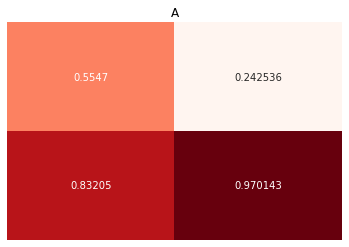

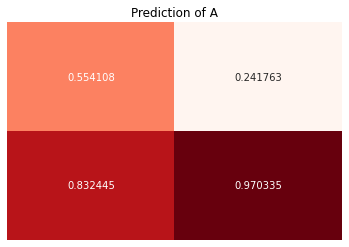

In [37]:
#comparaison entre A et sa prediction
import seaborn as sn
plt.figure(), plt.title("A"), plt.axis("off")
sn.heatmap(A, annot=True, cmap="Reds", cbar=False, fmt='g')

plt.figure(), plt.title("Prediction of A"), plt.axis("off")
sn.heatmap(A_estf2, annot=True, cmap="Reds", cbar=False, fmt='g')
plt.show()

In [38]:
A_v = A.ravel()
A_estf2_v = A_estf2.ravel()
mse = np.mean((A_v-A_estf2_v)**2)
print("MSE de A :", mse )

MSE de A : 2.85063620796572e-07


**Résponse** : Les A sont très proches, avec une MSE presque égale à 0, la séparation est donc très bonne

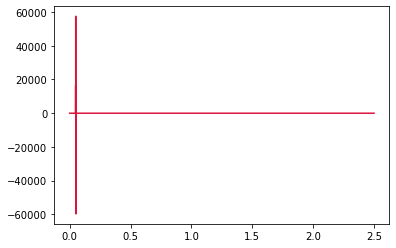

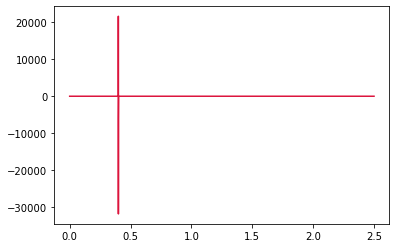

In [39]:
#affichage de la prediction de S
plt.figure(),plt.plot(x_abs/800 + 1.25, S_estf2[0,:], c="crimson")
plt.figure(),plt.plot(x_abs/800 + 1.25, S_estf2[1,:], c="crimson")
plt.show()

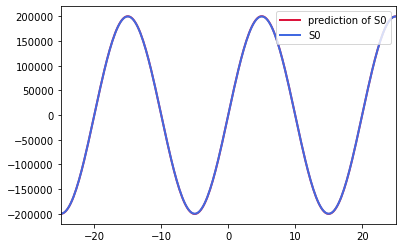

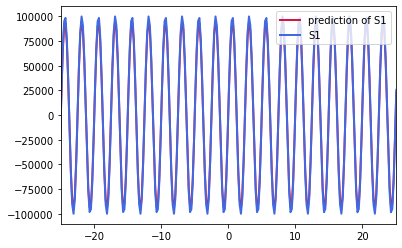

In [40]:
St_pred2 = sff.idct(S_estf2)

plt.figure()
plt.plot(x_abs, St_pred2[0,:], color="crimson", lw=2, label="prediction of S0")
plt.plot(x_abs, St[0,:], color="royalblue", lw=2, label="S0")
plt.legend(loc="upper right")
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, St_pred2[1,:], color="crimson", lw=2, label="prediction of S1")
plt.plot(x_abs, St[1,:], color="royalblue", lw=2, label="S1")
plt.legend(loc="upper right")
plt.xlim([-25,25])
plt.show()

On retrouve ici sur une petite échelle une très grande proximité entre S et sa prédiction. Il a cependant fallu augmenter $\lambda$, le paramètre de rélgularisation sur la sparsity de S. En effet avec $\lambda$ = 1000 la prédiction de Sf n'était pas assez sparse.

De plus, puisque la loss n'est pas convexe, il y a plusieurs minimas locaux, et il peut arriver d'avoir des résultats correspondant à ces minimas locaux. J'ai du executer plusieurs fois l'algorithme pour obtenir le minima global 